In [1]:
# Notebook: notebooks/01_exploration.ipynb

# Step 1: Import modules
import sys
sys.path.append('../src')

from preprocessing import load_and_clean, extract_features
from models import run_isolation_forest

# Step 2: Load and clean data
df = load_and_clean('../data/all_files_combined_evtx_logs.csv')

# Step 3: Extract features
features = extract_features(df)

In [2]:
# Step 4: Run Isolation Forest
scores, labels = run_isolation_forest(features)

# Step 5: Add scores to the dataframe
df['AnomalyScore'] = scores
df['IsAnomaly'] = labels

# Step 6: View result
df[['TimeCreated', 'EventID', 'Level', 'AnomalyScore', 'IsAnomaly']].head()


,TimeCreated,EventID,Level,AnomalyScore,IsAnomaly
0,2019-05-19 17:32:00.482983,1,4,0.048086,1
1,2019-05-16 01:38:19.630865,1,4,0.038225,1
2,2021-08-17 12:26:48.571022,0,0,0.056734,1
3,2021-08-17 12:26:48.578781,5,4,0.313128,1
4,2021-08-17 12:26:48.578840,5,4,0.313128,1


In [3]:
from models import run_lof

# Step 1: Run LOF
lof_scores, lof_labels = run_lof(features)

# Step 2: Add to DataFrame
df['LOF_Score'] = lof_scores
df['LOF_Anomaly'] = lof_labels  # -1 = anomaly, 1 = normal

# Step 3: Compare results (optional)
df[['TimeCreated', 'EventID', 'Level', 'AnomalyScore', 'IsAnomaly', 'LOF_Score', 'LOF_Anomaly']].head()

/Users/devyeshthomas/Workspace/College/NCI/AI-ML/CA2/tensorflow-env/lib/python3.9/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


,TimeCreated,EventID,Level,AnomalyScore,IsAnomaly,LOF_Score,LOF_Anomaly
0,2019-05-19 17:32:00.482983,1,4,0.048086,1,0.996023,1
1,2019-05-16 01:38:19.630865,1,4,0.038225,1,0.981879,1
2,2021-08-17 12:26:48.571022,0,0,0.056734,1,1.970321,-1
3,2021-08-17 12:26:48.578781,5,4,0.313128,1,1.000000,1
4,2021-08-17 12:26:48.578840,5,4,0.313128,1,1.000000,1


In [4]:
df[['EventID','TimeCreated', 'Provider', 'Task', 'Level']].head()

,EventID,TimeCreated,Provider,Task,Level
0,1,2019-05-19 17:32:00.482983,Microsoft-Windows-Sysmon,1,4
1,1,2019-05-16 01:38:19.630865,Microsoft-Windows-Sysmon,1,4
2,0,2021-08-17 12:26:48.571022,NaN,0,0
3,5,2021-08-17 12:26:48.578781,Microsoft-Windows-RPC,1,4
4,5,2021-08-17 12:26:48.578840,Microsoft-Windows-RPC,1,4


In [5]:
# Comparing overlap between the two models
(df['IsAnomaly'] != df['LOF_Anomaly']).mean()  # % disagreement

0.056672612291227505

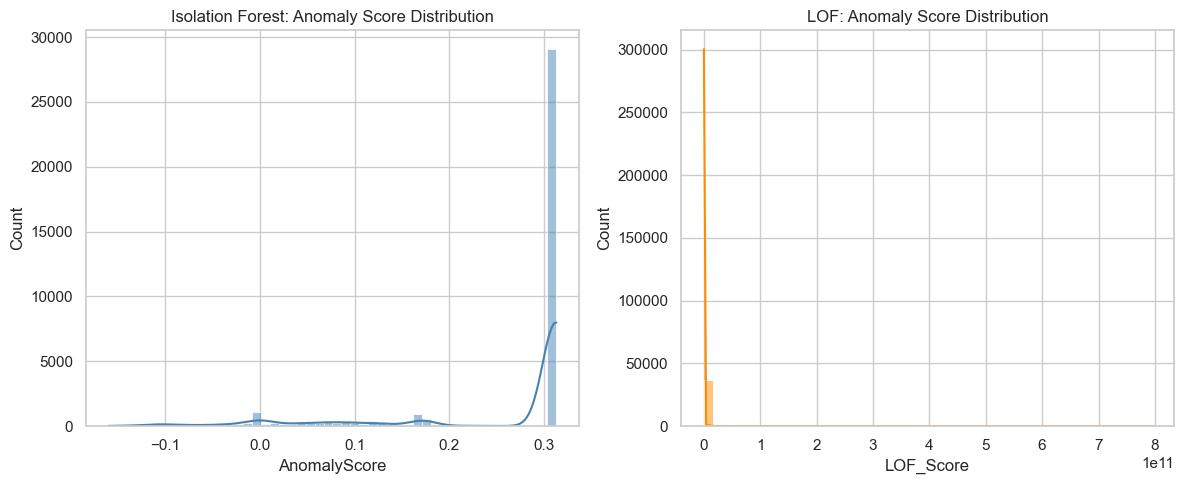

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up styling
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# Isolation Forest scores
plt.subplot(1, 2, 1)
sns.histplot(df['AnomalyScore'], bins=50, kde=True, color="steelblue")
plt.title("Isolation Forest: Anomaly Score Distribution")

# LOF scores
plt.subplot(1, 2, 2)
sns.histplot(df['LOF_Score'], bins=50, kde=True, color="darkorange")
plt.title("LOF: Anomaly Score Distribution")

plt.tight_layout()
plt.show()


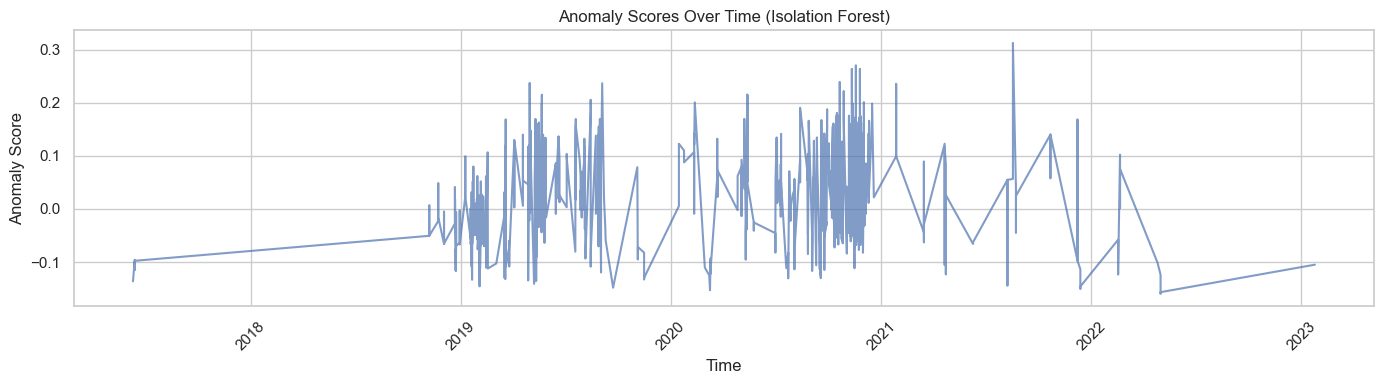

In [7]:
plt.figure(figsize=(14, 4))
df_sorted = df.sort_values("TimeCreated")

# Plot Isolation Forest anomalies over time
plt.plot(df_sorted["TimeCreated"], df_sorted["AnomalyScore"], label="Isolation Forest Score", alpha=0.7)
plt.title("Anomaly Scores Over Time (Isolation Forest)")
plt.xlabel("Time")
plt.ylabel("Anomaly Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from autoencoder import build_autoencoder
import numpy as np

# Step 1: Scale your features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 2: Train Autoencoder
model = build_autoencoder(X_scaled.shape[1])
history = model.fit(X_scaled, X_scaled,
                    epochs=10,
                    batch_size=64,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1)

# Step 3: Get reconstruction errors
X_pred = model.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - X_pred), axis=1)

# Step 4: Add to DataFrame
df["AE_Error"] = reconstruction_error

2025-05-01 22:51:24.150195: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-01 22:51:24.150378: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-01 22:51:24.150385: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-01 22:51:24.150653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-01 22:51:24.150664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-05-01 22:51:25.114879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


521/521 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.2410 - val_loss: 0.0619
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0095 - val_loss: 0.0159
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0030 - val_loss: 0.0132
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0022 - val_loss: 0.0125
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0018 - val_loss: 0.0120
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021 - val_loss: 0.0118
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0018 - val_loss: 0.0116
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0019 - val_loss: 0.0117
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0027 - val_loss: 0.0111
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021 - val_loss: 0.0107
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


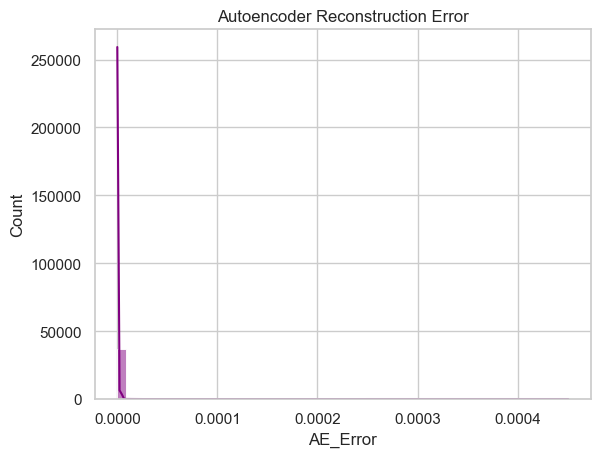

In [9]:
sns.histplot(df["AE_Error"], bins=50, kde=True, color="purple")
plt.title("Autoencoder Reconstruction Error")
plt.show()


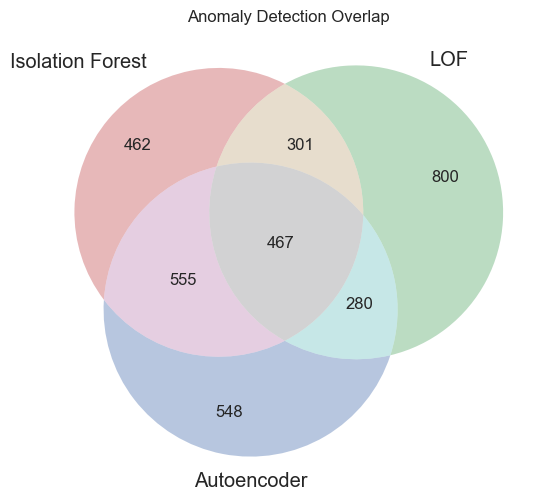

In [10]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Ensure labels are binary: 1 = anomaly, 0 = normal
df['IF_Label'] = (df['IsAnomaly'] == -1).astype(int)
df['LOF_Label'] = (df['LOF_Anomaly'] == -1).astype(int)

# Define top X% of AE errors as anomalies
threshold = df["AE_Error"].quantile(0.95)  # top 5%
df['AE_Label'] = (df["AE_Error"] > threshold).astype(int)

# Create sets for the venn
set_if  = set(df[df['IF_Label'] == 1].index)
set_lof = set(df[df['LOF_Label'] == 1].index)
set_ae  = set(df[df['AE_Label'] == 1].index)

# Plot Venn
plt.figure(figsize=(8, 6))
venn3([set_if, set_lof, set_ae], set_labels=('Isolation Forest', 'LOF', 'Autoencoder'))
plt.title("Anomaly Detection Overlap")
plt.show()


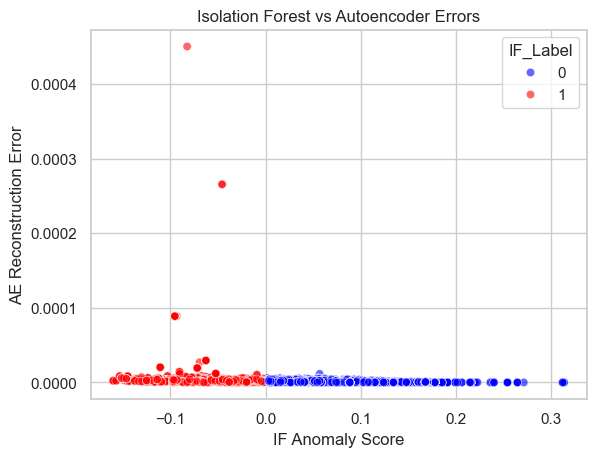

In [11]:
import seaborn as sns

# Plot IF vs AE Error
sns.scatterplot(data=df, x='AnomalyScore', y='AE_Error',
                hue='IF_Label', palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title("Isolation Forest vs Autoencoder Errors")
plt.xlabel("IF Anomaly Score")
plt.ylabel("AE Reconstruction Error")
plt.show()


In [12]:
# Save the DataFrame to be used in Streamlit
df.to_csv("../data/all_files_combined_evtx_logs.csv", index=False)
